In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import KFold, train_test_split, GridSearchCV

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)

from sklearn.metrics import accuracy_score
import missingno as msno

In [3]:

import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + "\\general_python_scripts") #need to add folder "general_python_scripts" to path to be able to import following module
import data_cleaning_functions


In [4]:
df=pd.read_csv("train.csv").drop('id', axis=1)
df= df[sorted(df.columns)] #sorts columns alphabetically
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54607 entries, 0 to 54606
Data columns (total 40 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               29892 non-null  float64
 1   capital_gains     29716 non-null  float64
 2   capital_losses    29850 non-null  float64
 3   citizenship       54607 non-null  object 
 4   class_worker      54607 non-null  object 
 5   country_father    52581 non-null  object 
 6   country_mother    52818 non-null  object 
 7   country_self      53532 non-null  object 
 8   det_hh_fam_stat   54607 non-null  object 
 9   det_hh_summ       54607 non-null  object 
 10  education         29786 non-null  object 
 11  fam_under_18      54607 non-null  object 
 12  full_or_part_emp  54607 non-null  object 
 13  high_income       54607 non-null  int64  
 14  hisp_origin       54377 non-null  object 
 15  hs_college        29771 non-null  object 
 16  ind_code_level1   54607 non-null  object

In [5]:
# identifying categorical data
df, categories = data_cleaning_functions.change_to_cat(df,threshold=10)

## Visualizing correlation between columns

In [6]:
df.corr().style.background_gradient(cmap="Blues")

,age,capital_gains,capital_losses,ind_code_level2,occ_code_level2,stock_dividends,wage_per_hour,weeks_worked
age,1.000000,0.086846,0.032291,0.172557,0.096012,0.139129,0.025130,0.270199
capital_gains,0.086846,1.000000,-0.012877,0.112036,0.010428,0.073411,-0.013556,0.160852
capital_losses,0.032291,-0.012877,1.000000,0.104572,0.038600,0.007851,0.012055,0.072779
ind_code_level2,0.172557,0.112036,0.104572,1.000000,0.424268,0.024666,0.145442,0.745850
occ_code_level2,0.096012,0.010428,0.038600,0.424268,1.000000,-0.026364,0.175640,0.552565
stock_dividends,0.139129,0.073411,0.007851,0.024666,-0.026364,1.000000,-0.012603,0.073053
wage_per_hour,0.025130,-0.013556,0.012055,0.145442,0.175640,-0.012603,1.000000,0.145167
weeks_worked,0.270199,0.160852,0.072779,0.745850,0.552565,0.073053,0.145167,1.000000


## analyzing missing values
checking all rows containing NaN's

In [7]:
null_per_column = pd.DataFrame({ col : [df[col].isnull().sum().sum()] for col in df.columns if df[col].isnull().sum().sum()!=0}, index=['number_of_nan',"ratio_of_nan"]).T.sort_values('number_of_nan')
null_per_column['ratio_of_nan'] = null_per_column['number_of_nan']/len(df)
null_per_column

,number_of_nan,ratio_of_nan
state_prev_res,184,0.003370
hisp_origin,230,0.004212
country_self,1075,0.019686
country_mother,1789,0.032761
country_father,2026,0.037101
weeks_worked,24197,0.443112
sex,24534,0.449283
age,24715,0.452598
capital_losses,24757,0.453367
education,24821,0.454539


In [8]:
df_at_least_one_missing = df[df.isna().any(axis=1)]
df_no_missing = df.dropna()

In [9]:
print(len(df_at_least_one_missing))
print(len(df_no_missing))

54216
391


### Visualizing missing values
source [here](https://towardsdatascience.com/visualizing-missing-values-in-python-is-shockingly-easy-56ed5bc2e7ea)


<AxesSubplot:>

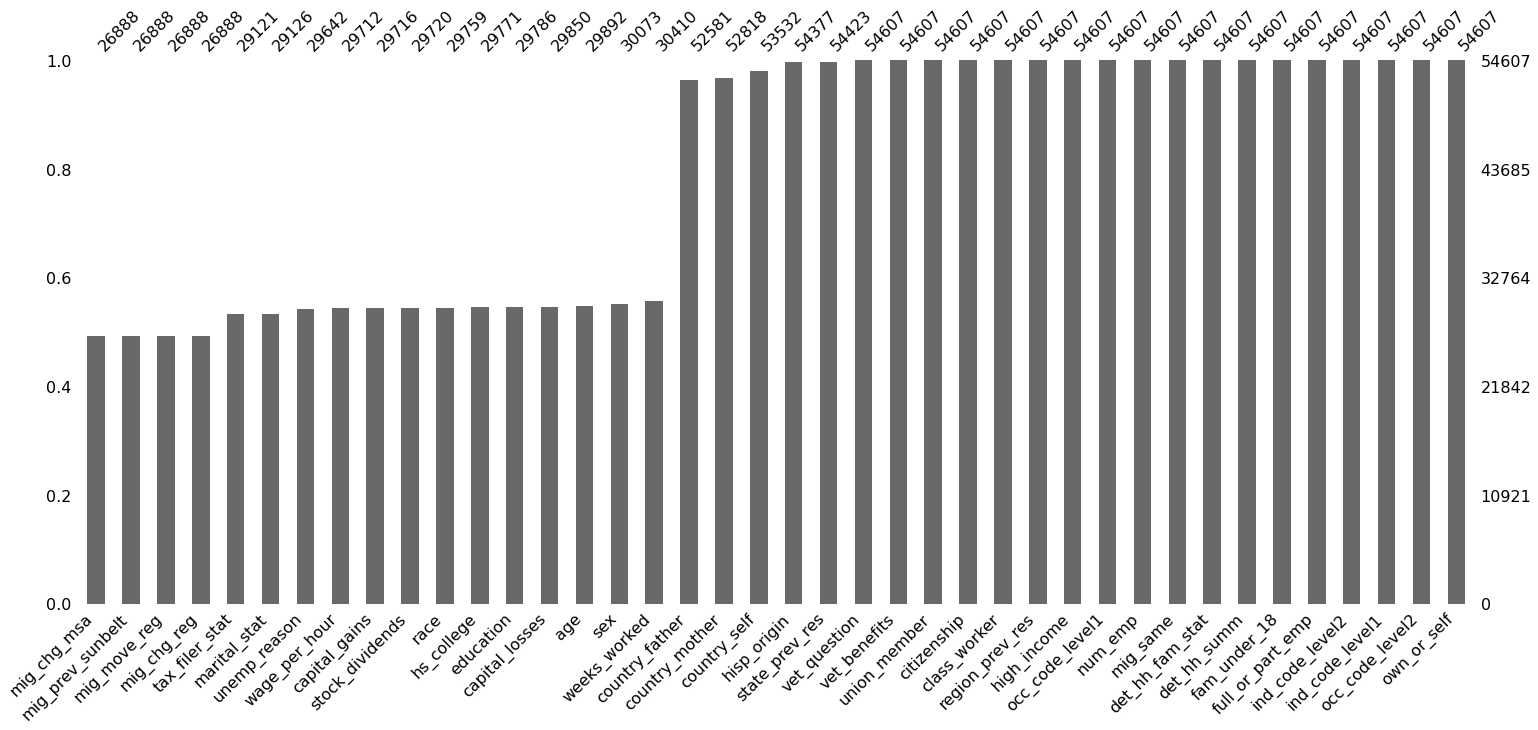

In [10]:
# Gives a bar chart of the missing values
msno.bar(df,sort="ascending")

one possibility could be cutting at 0.6

<AxesSubplot:>

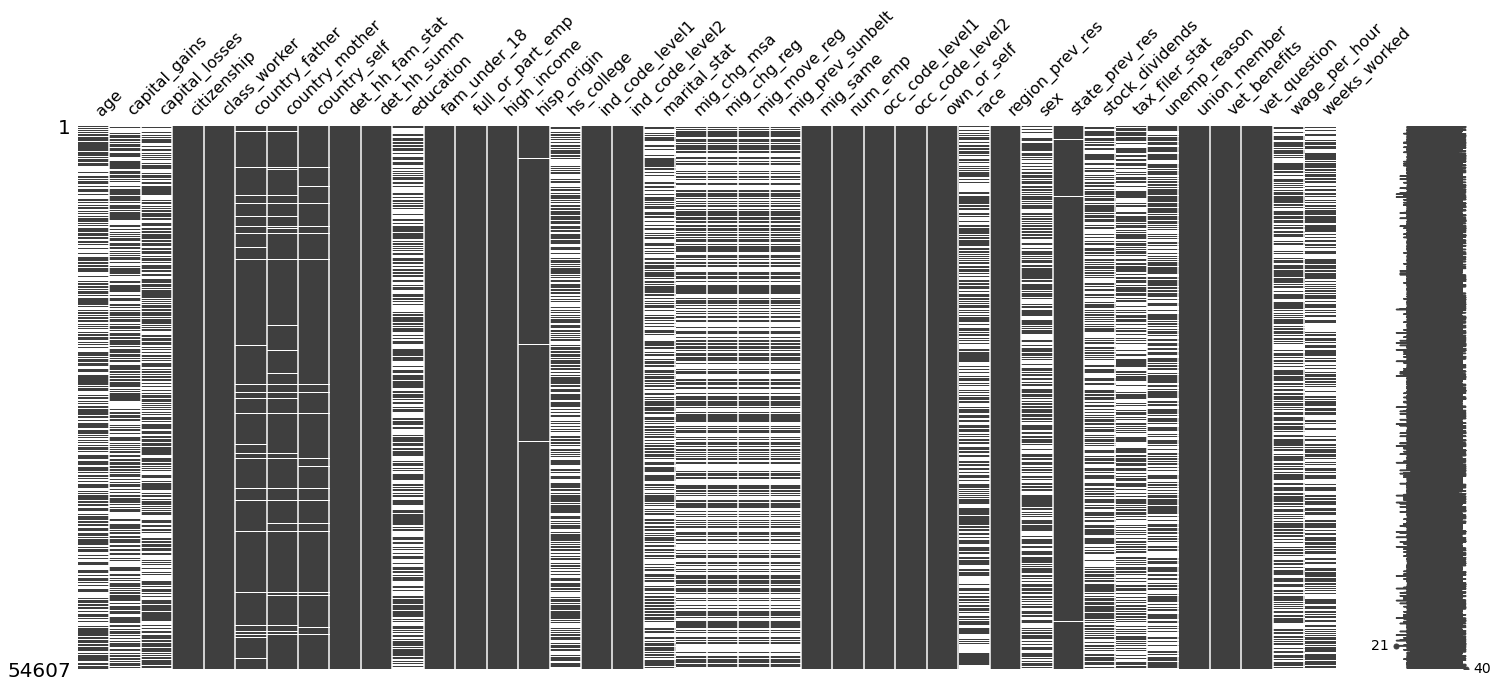

In [11]:
# Gives positional information of the missing values
msno.matrix(df)

<AxesSubplot:>

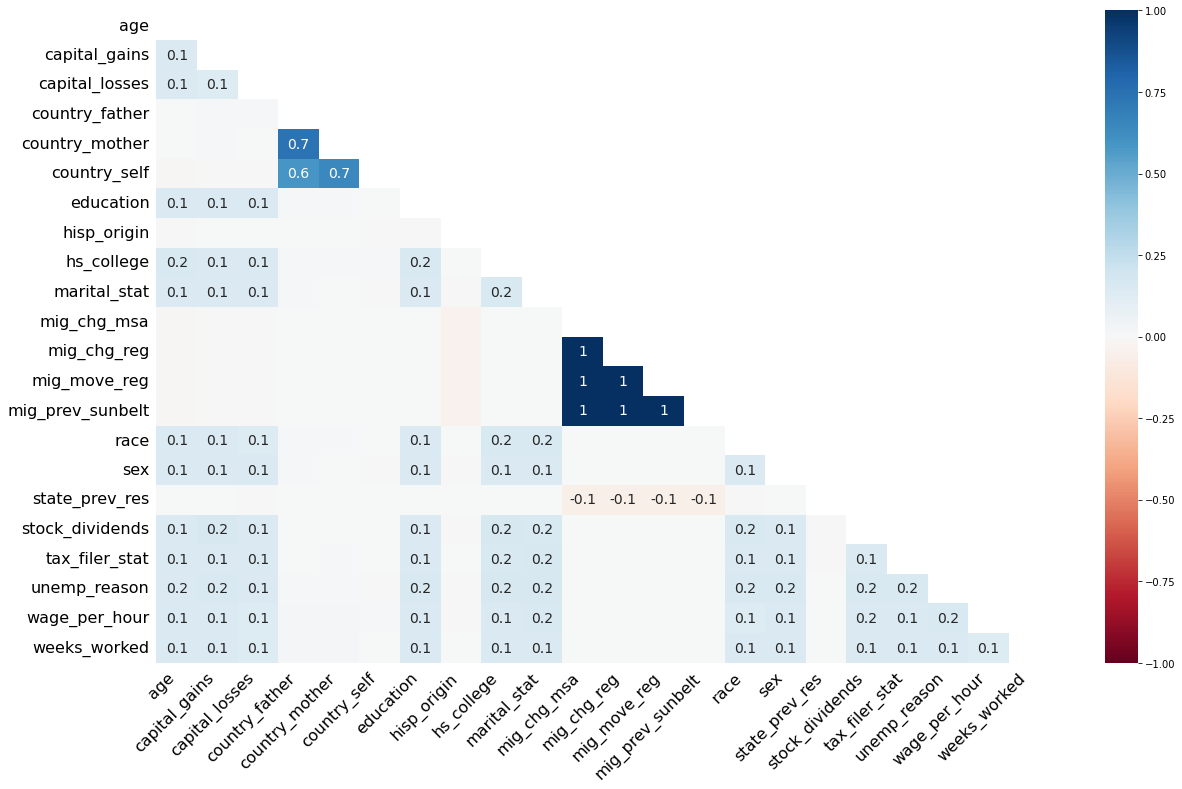

In [12]:
# Gives a heatmap of how missing values are related
msno.heatmap(df)

## Dealing with nan values

### on columns

In [13]:
threshold = 0.5
columns_to_remove = list(null_per_column[null_per_column['ratio_of_nan'] > threshold].index)
columns_to_remove
df = df.drop(columns_to_remove, axis=1)

### re-visualization after removing columns

<AxesSubplot:>

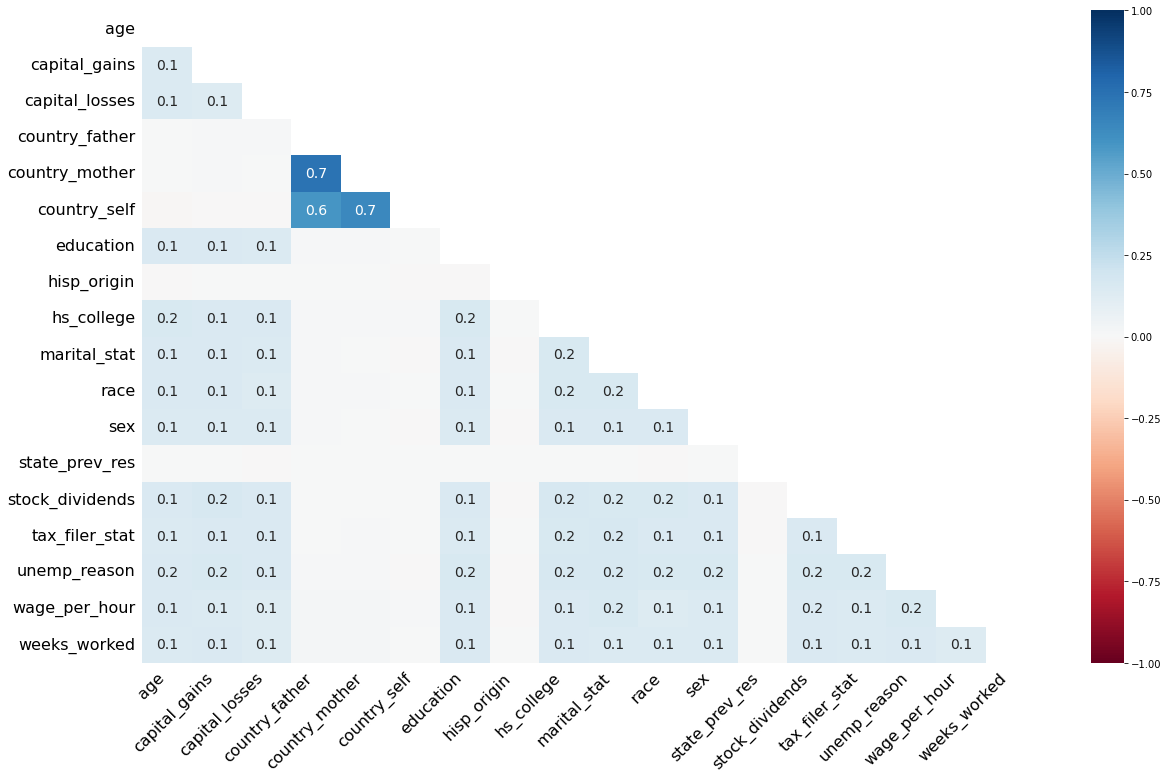

In [14]:
# Gives a heatmap of how missing values are related
msno.heatmap(df)

### on rows

In [15]:
df_of_amount_of_nan = pd.DataFrame({"col" : [df.loc[k].isna().sum() for k in df.index]}, index = df.index)
df_of_amount_of_nan.columns=['number_of_nan']
df_of_amount_of_nan.sort_values('number_of_nan')

,number_of_nan
22084,0
45945,0
22433,0
22396,0
46041,0
...,...
215,15
37853,15
21818,15
44374,15


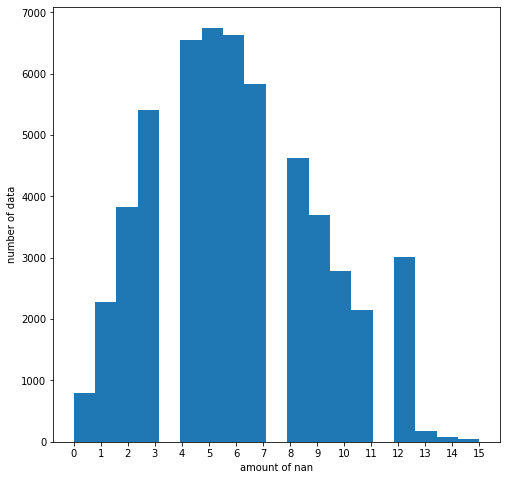

In [16]:
plt.figure(figsize=(8,8))
plt.xlabel('amount of nan')
plt.ylabel('number of data')
plt.xticks([k for k in range(20)])
plt.hist(df_of_amount_of_nan, 19);

In [17]:
threshold = 8
index_to_drop = df_of_amount_of_nan[df_of_amount_of_nan['number_of_nan'] > threshold].index
df_below_nan_threshold = df.drop(index_to_drop, axis=0)

In [18]:
print("new amount of data with at least one nan value : ", len(df_below_nan_threshold[df_below_nan_threshold.isna().any(axis=1)]))

new amount of data with at least one nan value :  41868


In [19]:
null_per_column = pd.DataFrame({ col : [df_below_nan_threshold[col].isnull().sum().sum()] for col in df_below_nan_threshold.columns if df_below_nan_threshold[col].isnull().sum().sum()!=0}, index=['number_of_nan']).T.sort_values('number_of_nan')
null_per_column

,number_of_nan
state_prev_res,118
hisp_origin,165
country_self,537
country_mother,918
country_father,1070
weeks_worked,14902
sex,15152
hs_college,15265
unemp_reason,15304
age,15328


## dealing with categorical data

In [20]:
df_changed, categories = data_cleaning_functions.change_to_cat(df,threshold=15)

In [ ]:
categories